In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten
import scipy.stats as st
import math
import numpy.random as random

We first implement the conditional intensity function for SE (multiple stations) model.

In [2]:
def cond_int_fun_diff(t, times, param_i, n, dist):
    """
    Find the value of the conditional intensity function at time t using given parameters.
    """
    beta_d, theta_d, lambda_i, k_d = param_i[0], param_i[1], param_i[2], param_i[3]
    
    for j in range(n):
        
        ind = np.searchsorted(times[j], t, side='right')
        if ind > 0:
            kappa_d = np.exp(- k_d * dist[j])
           
            lambda_i += np.sum(kappa_d * beta_d * np.exp(-theta_d*(t-times[j][0:ind]))) 
       
    return lambda_i

And then we implement the function to simulate data.

In [3]:
def kappa_fun(dist, k):
    
    return np.exp(-k * dist)

And then we implement the function to simulate data.

In [4]:
def diff_sim(M, beta, theta, lambda_i, dist, k, n):
    
    #(Lambda_mat)ij = lambda_i^j: the effect of the jth process on the ith process
    lambda_mat = np.zeros((M, M))
    ZX_mat = np.zeros((n, 2), dtype=int)
    N_array = np.zeros(M)
    r_array = []
    r_prev = 0
    times = {}
    
    for m in range(M):
        lambda_mat[m, :] = kappa_fun(dist[m, :], k[m]) * beta[m]
        beta_mat = lambda_mat*1.0
        times[m] = []
        
    for j in range(n):
        a_mat = np.zeros((M, M+1))
        
        for m in range(M):
            a_mat[m, 0] = random.exponential(1/lambda_i[m], 1)[0]
            for i in range(M):
                u = random.uniform(low = 0.0, high = 1.0, size = 1)[0]
                if u < 1 - np.exp(-1/theta[m]*lambda_mat[m, i]):
                    a_mat[m, i+1] = -1/theta[m]*np.log(1+theta[m]/lambda_mat[m, i]*np.log(1-u))
                else:
                    a_mat[m, i+1] = np.Inf
                
        r_next = r_prev + np.min(a_mat)
        r_array.append(r_next)
        ind = np.argmin(a_mat)
        ZX_mat[j, 0] = int(np.unravel_index([ind], (M, M+1))[0][0])
        ZX_mat[j, 1] = int(np.unravel_index([ind], (M, M+1))[1][0])
                
        for m in range(M):
            lambda_mat[m, :] *= np.exp(-theta[m]*(r_next - r_prev))
            lambda_mat[m, ZX_mat[j, 0]] += beta_mat[m, ZX_mat[j, 0]]                
        
        N_array[ZX_mat[j, 0]] += 1
        r_prev = r_next
        times[ZX_mat[j, 0]].append(r_next)
    
    return times

We do some simulations on given parameters.

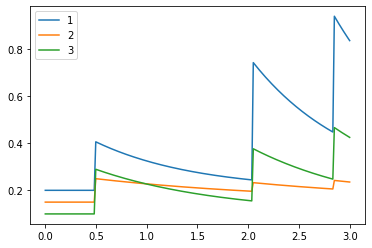

{0: [2.0454490370727316, 2.8378157791280856], 1: [0.48355247035968135], 2: [3.066119952014662, 3.3962769215396125]}


In [5]:
n = 3
#para = {0: [0.5, 1.0, 1.0, 1.75], 1:[0.1, 0.1, 0.05, 2.25], 2: [0.3, 0.3, 0.2, 1.5]}
#para_mat = np.zeros((n, 4))
#for i in range(n):
    #para_mat[i, :] = para[i]

beta = [0.5, 0.1, 0.3]
theta = [1.0, 0.5, 0.8]
lambda_i = [0.2, 0.15, 0.1]
k = [1.75, 2, 1.5]

param = np.array([beta, theta, lambda_i, k]).T
dist_arr = np.array([[0, 0.5, 0.2], 
                 [0.5, 0, 0.3], 
                 [0.2, 0.3, 0]])

times = diff_sim(3, beta, theta, lambda_i, dist_arr, k, 9)
times[0] = times[0][0:2]
times[1] = times[1][0:2]
times[2] = times[2][0:2]

times

t = np.linspace(0, 3, 200)
lamb_1 = []
lamb_2 = []
lamb_3 = []

for i in range(len(t)):
    lambda_1 = cond_int_fun_diff(t[i], times, param[0, :], 3, dist_arr[0, :])
    lamb_1.append(lambda_1)
    lambda_2 = cond_int_fun_diff(t[i], times, param[1, :], 3, dist_arr[1, :])
    lamb_2.append(lambda_2)
    lambda_3 = cond_int_fun_diff(t[i], times, param[2, :], 3, dist_arr[2, :])
    lamb_3.append(lambda_3)
     
plt.plot(t, lamb_1, label='1');
plt.plot(t, lamb_2, label='2');
plt.plot(t, lamb_3, label='3');
plt.legend()
plt.show();


print(times)

We need some previous functions for running optimisation on simulated data.

In [6]:
def prev_event(times, T):
    """
    Return the event times in process j that happens before event time T in process i.
    : param times: an n-dimensional array, the full event times in process j
    : param T: a number, one event time in process i
    
    : return k: a number, the index of the last event time in process j happened before T in process i
    """
    
    return np.searchsorted(times, T, side='right')

In [7]:
def process_times(location_codes, times, i):
    """
    Return the event times observed at station j = 1, ..., m, before the last event time
    observed in departure process at station i.
    
    : param location_codes: a list of length M, the location codes of all M stations, with i as the first.
    : param times: a dictionary, storing the departure times from station j = 1, ..., M as values, \
    and the location codes of corresponding stations as keys.
    : param i: the index of the station being studied
    
    : return times: a dictionary, storing all relevant event times
    """
    
    #ii = get_station_index(location_codes, i)
    T = times[i][-1]
    ind_list = []
    new_times = {}
    
    for j in range(len(location_codes)):
        ind = prev_event(times[location_codes[j]], T)
        if j != i and ind != 0:
            new_times[location_codes[j]] = times[location_codes[j]][:ind]
        
        if ind == 0:
            ind_list.append(location_codes[j])
        
        if j == i:
            new_times[location_codes[j]] = times[location_codes[j]]
            
    return new_times, ind_list

In [8]:
def A_ii(theta, times_i):
    """
    Finds the array of function A_i, from 1st event to hth event in process i
    
    : param theta: a real number
    : param times_i, a 1-D array, the event times observed in process i
    
    : return A: a 1D array
    """
   
    A = np.zeros(len(times_i))
    
    for h in range(1, len(times_i)):
        A[h] = np.exp(-theta*(times_i[h] - times_i[h-1]))*(1+A[h-1])
        
    return A

In [9]:
def A_ij(theta, times_i, times_j):
    """
    Finds the array of function A_ij, for all event times in process j = 1, ..., M
    
    : param theta: a real number
    : param times_i, a 1-D array, the event times observed in process i
    : param times_j, a 1-D array, the event times observed in process j
    
    : return B: a 1-D array
    """
    
    B = np.zeros(len(times_i))
    ind = prev_event(times_j, times_i[0])
    
    B[0] = np.sum(np.exp(- theta * (times_i[0] - times_j[:ind])))
    
    for h in range(1, len(times_i)):
        B[h] = np.exp(-theta * (times_i[h] - times_i[h-1])) * B[h-1] 
        new_ind = prev_event(times_j, times_i[h])
        if ind != new_ind:
            B[h] += np.sum(np.exp(- theta * (times_i[h] - times_j[ind:new_ind])))
            ind = new_ind#prev_event(times_j, times_i[h])
        
    return B

In [10]:
def excitation_j(theta, t, times_j):
    """
    Finds the array of function excitation_j, for all event times in process j = 1, ..., M
    
    : param theta: a real number, thetaj
    : param times_i, a 1-D array, the event times observed in process i
    : param times_j, a 1-D array, the event times observed in process j
    
    : return Ej: a 1-D array
    """
     #Ej = 0
    ind = prev_event(times_j, t)
    Ej = np.zeros(ind)
    if ind != 0:
            Ej = np.exp(-theta*(t - times_j[0:ind])) - 1
    #for i in range(ind):
        #Ej += np.exp(-theta*(t - times_j[i])) - 1
    
    return Ej

In [11]:
def diff_log_likelihood(location_codes, event_times, beta, theta, lambda_b, k, dist, i): 
    """
    Finds the log-likelihood of the mutually exciting process between stations
    
    : param location_codes: a list of length M, the location codes of all M stations with i as the first
    : param event_times: a dictionary, the event times in all processes \
      that occurred before the last event in process i 
    : param beta: a real number
    : param theta: a real number
    : param k: a real number
    : param dist: a 1-D array of length M, which stores the distances of each station
    : param lambda_b: a real number, the baseline intensity of station i
    : prarm i: the index of the station being studied
    
    : return A: a real number, the baseline intensity of station i
    """
    #ind = get_station_index(location_codes, i)
    ind = i
    times_i = event_times[i]
    
    kappa = kappa_fun(dist, k)
    ratio = kappa*beta/theta
    T = times_i[-1]
    
    A = A_ii(theta, times_i)
    A = kappa[ind]*beta*A
    ex_terms = ratio[ind] * np.sum(excitation_j(theta, T, times_i))
    
    for j in range(len(location_codes)):
        if j != ind:
            A += kappa[j] * beta * A_ij(theta, times_i, event_times[location_codes[j]])
            ex_terms += ratio[j] * np.sum(excitation_j(theta, T, event_times[location_codes[j]]))
    
    res = np.sum(np.log(lambda_b +A)) + ex_terms - lambda_b*T
    
    return res

In [12]:
def get_station_index(loc_codes, i):
    """Find the index of given station id i in the array location codes
    
    :param i: station id
    :return ind: the inderx
    """
    
    return loc_codes.index(i)

In [13]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)

We run the simulation 500 times, each time generating a dataset with 3 processes, and 2700 time points in total.

In [14]:
n =500
M = 3

#para = {0: [0.5, 1.0, 1.5, 1.75], 1:[0.4, 0.9, 1.8, 2.0], 2: [0.3, 0.8, 2.2, 1.5]}
#para_mat = np.zeros((n, 4))
#for i in range(n):
   # para_mat[i, :] = para[i]
    
#dist_arr = np.array([[0, 0.5], 
                    #[0.5, 0])
    
beta = [0.5, 0.1, 0.3]
theta = [1.0, 0.5, 0.8]
lambda_i = [0.2, 0.15, 0.1]
k = [1.75, 2, 1.5]

param = np.array([beta, theta, lambda_i, k]).T
dist_arr = np.array([[0, 0.5, 0.2], 
                 [0.5, 0, 0.3], 
                 [0.2, 0.3, 0]])

loc_codes = [0, 1, 2]

para_0 = np.zeros((n, 4))
para_1 = np.zeros((n, 4))
para_2 = np.zeros((n, 4))

x0_init = [np.log(0.5), np.log(1.0-0.5), np.log(0.2), np.log(1.75)]
x1_init = [np.log(0.1), np.log(0.5-0.1), np.log(0.15), np.log(2)]
x2_init = [np.log(0.3), np.log(0.8-0.3), np.log(0.1), np.log(1.5)]

for i in range(n):
    print('Iteration: ', i+1, '/',n, end='\r')
    times = diff_sim(3, beta, theta, lambda_i, dist_arr, k, 2700)
    t_0 = process_times(loc_codes, times, 0)[0]
    t_1 = process_times(loc_codes, times, 1)[0]
    t_2 = process_times(loc_codes, times, 2)[0]
    
    mle_0 = op.minimize(op_diff_log_likelihood, x0 = x0_init, method = 'Nelder-Mead', args=(loc_codes, t_0, dist_arr[0, :], 0))
    mle_1 = op.minimize(op_diff_log_likelihood, x0 = x1_init, method = 'Nelder-Mead', args=(loc_codes, t_1, dist_arr[1, :], 1))
    mle_2 = op.minimize(op_diff_log_likelihood, x0 = x2_init, method = 'Nelder-Mead', args=(loc_codes, t_2, dist_arr[2, :], 2))
    
    para_0[i, :] = mle_0.x
    para_1[i, :] = mle_1.x
    para_2[i, :] = mle_2.x

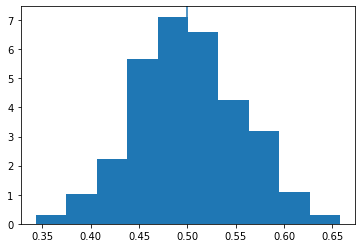

In [15]:
plt.hist(np.exp(para_0[:n, 0]), density=True)
plt.axvline(x=0.5)
plt.show()

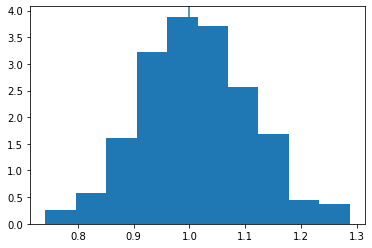

In [16]:
plt.hist(np.exp(para_0[:n, 0])+ np.exp(para_0[:n, 1]), density=True)
plt.axvline(x=1.0)
plt.show()

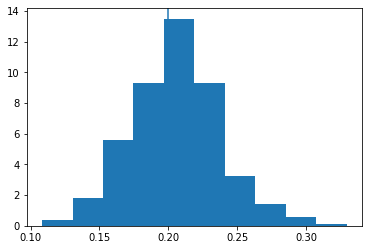

In [17]:
plt.hist(np.exp(para_0[:n, 2]), density=True)
plt.axvline(x=0.2)
plt.show()

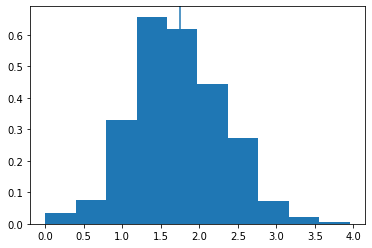

In [18]:
plt.hist( np.exp(para_0[:n, 3]), density=True)
plt.axvline(x=1.75)
plt.show()

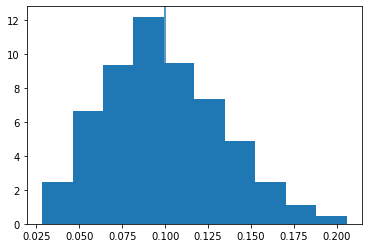

In [19]:
plt.hist(np.exp(para_1[:n, 0]), density=True)
plt.axvline(x=0.1)
plt.show()

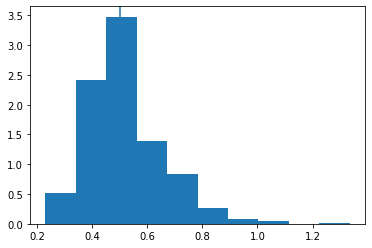

In [20]:
plt.hist(np.exp(para_1[:n, 0])+ np.exp(para_1[:n, 1]), density=True)
plt.axvline(x=0.5)
plt.title('')
plt.show()

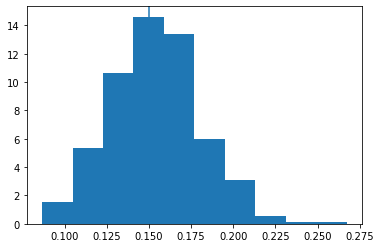

In [21]:
plt.hist(np.exp(para_1[:n, 2]), density=True)
plt.axvline(x=0.15)
plt.show()

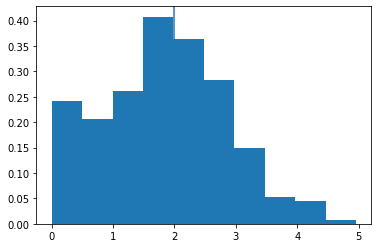

In [22]:
plt.hist( np.exp(para_1[:n, 3]), density=True)
plt.axvline(x=2)
plt.show()

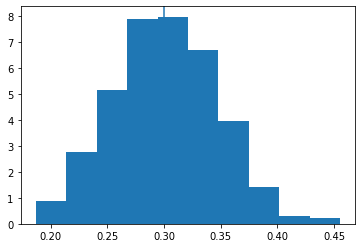

In [23]:
plt.hist(np.exp(para_2[:n, 0]), density=True)
plt.axvline(x=0.3)
plt.show()

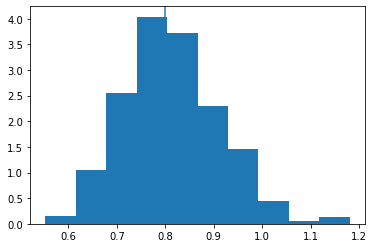

In [24]:
plt.hist(np.exp(para_2[:n, 0])+ np.exp(para_2[:n, 1]), density=True)
plt.axvline(x=0.8)
plt.show()

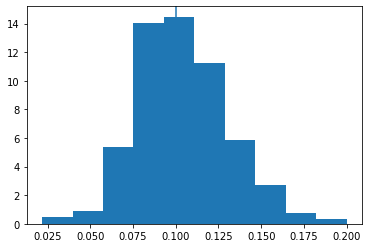

In [25]:
plt.hist(np.exp(para_2[:n, 2]), density=True)
plt.axvline(x=0.1)
plt.show()

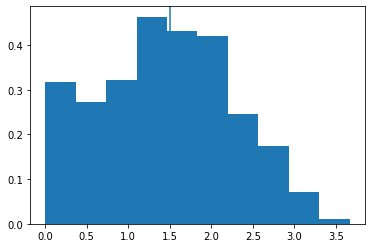

In [26]:
plt.hist( np.exp(para_2[:n, 3]), density=True)
plt.axvline(x=1.5)
plt.show()

And we combine all plots together.

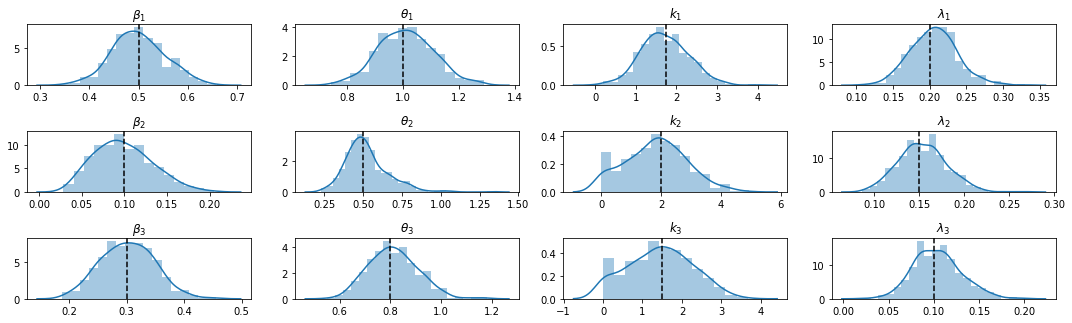

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, axes = plt.subplots(3, 4, figsize=(15, 5))

sns.distplot(np.exp(para_0[:n, 0]), ax=axes[0, 0], hist=True, kde=True)
axes[0, 0].set_title(r'$\beta_1$')
axes[0, 0].axvline(0.5, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_0[:n, 0]) + np.exp(para_0[:n, 1]), ax=axes[0, 1], hist=True, kde=True)
axes[0, 1].set_title(r'$\theta_1$')
axes[0, 1].axvline(1.0, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_0[:n, 3]), ax=axes[0, 2], hist=True, kde=True)
axes[0, 2].set_title(r'$k_1$')
axes[0, 2].axvline(1.75, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_0[:n, 2]), ax=axes[0, 3], hist=True, kde=True)
axes[0, 3].set_title(r'$\lambda_1$')
axes[0, 3].axvline(0.2, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_1[:n, 0]), ax=axes[1, 0], hist=True, kde=True)
axes[1, 0].set_title(r'$\beta_2$')
axes[1, 0].axvline(0.1, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_1[:n, 0])+np.exp(para_1[:n, 1]), ax=axes[1, 1], hist=True, kde=True)
axes[1, 1].set_title(r'$\theta_2$')
axes[1, 1].axvline(0.5, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_1[:n, 3]) , ax=axes[1, 2], hist=True, kde=True)
axes[1, 2].set_title(r'$k_2$')
axes[1, 2].axvline(2, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_1[:n, 2]), ax=axes[1, 3], hist=True, kde=True)
axes[1, 3].set_title(r'$\lambda_2$')
axes[1, 3].axvline(0.15, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_2[:n, 0]), ax=axes[2, 0], hist=True, kde=True)
axes[2, 0].set_title(r'$\beta_3$')
axes[2, 0].axvline(0.3, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_2[:n, 0])+np.exp(para_2[:n, 1]), ax=axes[2, 1], hist=True, kde=True)
axes[2, 1].set_title(r'$\theta_3$')
axes[2, 1].axvline(0.8, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_2[:n, 3]) , ax=axes[2, 2], hist=True, kde=True)
axes[2, 2].set_title(r'$k_3$')
axes[2, 2].axvline(1.5, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_2[:n, 2]), ax=axes[2, 3], hist=True, kde=True)
axes[2, 3].set_title(r'$\lambda_3$')
axes[2, 3].axvline(0.1, color = 'black', linestyle = '--')


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('smes sim.pdf')

And produce a boxplot for KS statistics.

In [ ]:
data = [ks_dep, ks_arr]
plt.boxplot(data)

plt.xticks([1, 2], ['SME (single station): ' + r'$N_{dep}(t)$', 'SME (single station): ' + r'$N_{arr}(t)$'])
plt.savefig('sme box.pdf')